In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import rtbm.layers as layers
import rtbm.model as mdl

import warnings
warnings.filterwarnings('ignore')

from rtbm.costfunctions import mse, crossentropy
from rtbm.activations import tanh, sigmoid
from rtbm.initializers import uniform, normal

from rtbm import minimizer

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

from scipy import signal


# Example 1: Sine-Mixture with gaussian noise

In [2]:
def func(x,n):
    return 0.5*np.sin(1*x+0.1)+0.75*np.sin(0.25*x-0.3)+n*np.random.normal(0,0.2,x.shape[2])

X = np.linspace(0, 100, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

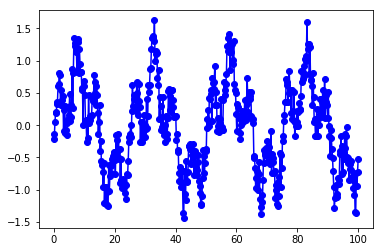

In [3]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

## via CMA

In [4]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(1,3))
M.add(layers.DiagExpectationUnitLayer(3,3))
M.add(layers.DiagExpectationUnitLayer(3,1))

#print(M.get_layer(2)._w)

In [ ]:
minim = minimizer.CMA(False)
minim.train(mse, M, X, Y, tolfun=1e-4)

CMA on 1 cpu(s) enabled
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 29 (seed=488870, Fri Nov 10 13:53:22 2017)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 4.546287401661520e-01 1.0e+00 1.04e+00  1e+00  1e+00 0:00.0
    2     28 4.297540113283063e-01 1.1e+00 1.02e+00  1e+00  1e+00 0:00.2
    3     42 4.423956916506158e-01 1.1e+00 1.01e+00  1e+00  1e+00 0:00.4
   25    350 4.328556306430592e-01 1.5e+00 1.08e+00  1e+00  1e+00 0:03.5
   58    812 4.253502850418214e-01 1.8e+00 9.51e-01  8e-01  1e+00 0:07.6
   99   1386 4.216721494572997e-01 2.2e+00 5.06e-01  4e-01  6e-01 0:12.7
  100   1400 4.234043161151358e-01 2.2e+00 4.93e-01  4e-01  6e-01 0:12.8
  157   2198 4.365903811788403e-01 3.3e+00 6.12e-01  4e-01  8e-01 0:19.8
  200   2800 4.162439387314921e-01 3.7e+00 3.80e-01  2e-01  5e-01 0:25.1
  273   3822 3.821759616839309e-01 5.2e+00 2.89e-01  1e-01  4e-01 0:34.2
  300   4200 3.980906116543472e-01 5.9e+00 3.07e-01  1e-01  4e-01 0:37.5
  390   5

In [ ]:
npoints = 500
test_X = (np.linspace(0, 100, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"b-", label='fit')
plt.legend()

In [ ]:
M.get_layer(3).show_activation(1,10)

## via SGD

In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,3))
M.add(layers.DiagExpectationUnitLayer(3,3))
M.add(layers.DiagExpectationUnitLayer(3,1))

minim = minimizer.SGD()
minim.train(mse, M, X, Y, lr=0.1, maxiter=1000, nesterov=True,momentum=0.1, batch_size=100)

In [ ]:
M.get_layer(1).show_activation(1,1)

In [ ]:
npoints = 500
test_X = (np.linspace(0, 100, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
plt.legend()

# Example 2: Sine-Cosine-Mixture with trend and gaussian noise

In [ ]:
def func(x,n):
    return 0.02*x+0.5*np.sin(1*x+0.1)+0.75*np.cos(0.25*x-0.3)+n*np.random.normal(0,0.2,x.shape[2])

X = np.linspace(0, 100, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

In [ ]:
Y = func(X[:,None],0).reshape((1,X.shape[1]))

plt.plot(X.flatten(), Y.flatten(),"-")
plt.xlabel("t")
plt.ylabel("y")
#plt.savefig("sincosmix.eps", format="eps")
plt.show()


In [ ]:
Y = func(X[:,None],1).reshape((1,X.shape[1]))

plt.plot(X.flatten(), Y.flatten(),"-")
plt.xlabel("t")
plt.ylabel("y")
#plt.savefig("sincosmix_noise.eps", format="eps")

plt.show()



In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,3))
M.add(layers.DiagExpectationUnitLayer(3,3))
M.add(layers.DiagExpectationUnitLayer(3,2))
M.add(layers.DiagExpectationUnitLayer(2,1))

In [ ]:
minim = minimizer.CMA(parallel=True)
minim.train(mse, M, X, Y, tolfun=1e-4)

In [ ]:
npoints = 500
test_X = (np.linspace(0, 100, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og", label='train')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"b-", label='fit', linewidth=5)
plt.legend()
plt.xlabel("t")
plt.ylabel("y")
#plt.savefig("sincosmix_10-4.eps", format="eps")
plt.show()

# Example: Intrawave modulation

In [ ]:
def func(x,n):
    return np.cos(0.01*x+0.5*np.cos(0.05*x))/(2+np.sin(0.04*x))

X = np.linspace(0, 1000, 1000)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

plt.plot(X.flatten(), Y.flatten(),"b-")

In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,5, phase=1j))
M.add(layers.DiagExpectationUnitLayer(5,5, phase=1j))
M.add(layers.DiagExpectationUnitLayer(5,3, phase=1j))
M.add(layers.DiagExpectationUnitLayer(3,1, phase=1j))

In [ ]:
minim = minimizer.CMA(False)
minim.train(mse, M, X, Y, maxiter=1000)

In [ ]:
npoints = 1000
test_X = (np.linspace(0, 1000, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og", label='train')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"b-", label='fit', linewidth=5)
plt.legend()
plt.xlabel("t")
plt.ylabel("y")

# Example 3: Saw-tooth

In [ ]:
def func(x,n):
    return signal.sawtooth(x)

X = np.linspace(0, 30, 500)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None],1).reshape((1,X.shape[1]))

In [ ]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [ ]:
M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,10, phase=1j))
M.add(layers.DiagExpectationUnitLayer(10,1, phase=1j))

minim = minimizer.CMA(parallel=False)
minim.train(mse, M, X, Y, maxiter=1000)

In [ ]:
npoints = 500
test_X = (np.linspace(0, 30, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
#plt.savefig("sawtooth_reg.eps", format="eps")
plt.legend()

# Example 3: MNIST (via CMA)

In [ ]:
# Load MNIST dataset
MNIST_train = pd.read_csv('~/data/mnist_train.csv', delimiter=",",header=None).values
MNIST_test  = pd.read_csv('~/data/mnist_test.csv', delimiter=",",header=None).values

# Prepare data (normalized onto [0,1])
Y_train = MNIST_train[0:10000,0]
X_train = MNIST_train[0:10000,1:]/255.0

Y_test = MNIST_test[:,0]
X_test = MNIST_test[:,1:]/255.0

enc = LabelBinarizer()
enc.fit(np.diag([1,1,1,1,1,1,1,1,1,1]))
enc.classes_ = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
T=enc.transform(Y_train).T


In [ ]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(784,10, param_bound=50))
#M.add(layers.DiagExpectationUnitLayer(10,10))
#M.add(layers.DiagExpectationUnitLayer(10,10))
M.add(layers.SoftMaxLayer(10))

In [ ]:
minim = minimizer.CMA(False)

sol=minim.train(mse(), M, np.transpose(X_train), T, maxiter=100)

In [ ]:
P=np.argmax(M.predict(np.transpose(X_train)),axis=0)

print(classification_report(Y_train,P.T))
print(confusion_matrix(Y_train, P.T))

In [ ]:
P=np.argmax(M.predict(np.transpose(X_test)),axis=0)


print(classification_report(Y_test,P.T))
print(confusion_matrix(Y_test, P.T))

In [ ]:
M.get_layer(1).show_activation(10,1)

# Example 4: MNIST (via SGD)

In [ ]:
M = mdl.Model()

#M.add(layers.NonLinear(784,10,sigmoid()))
M.add(layers.DiagExpectationUnitLayer(784,10))

M.add(layers.Linear(10,10))
M.add(layers.SoftMaxLayer(10))


In [ ]:
minim = minimizer.SGD()

sol=minim.train(mse, M, np.transpose(X_train), T, lr=0.001, decay=0.01, maxiter=100, log_step=10, batch_size=1000)

In [ ]:
P=np.argmax(M.predict(np.transpose(X_train)),axis=0)

print(classification_report(Y_train,P.T))
print(confusion_matrix(Y_train, P.T))

In [ ]:
P=np.argmax(M.predict(np.transpose(X_test)),axis=0)


print(classification_report(Y_test,P.T))
print(confusion_matrix(Y_test, P.T))

In [ ]:
M.get_layer(1).show_activation(10,10)